In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
train_X = pd.read_csv("train_X.csv").set_index('mid')
train_X_normalized = pd.read_csv("train_X_normalized.csv").set_index('mid')
train_y = pd.read_csv('train_y.csv').set_index('mid')['radiant_win']

In [90]:
def draw(results, param, title, limit=None):
    if limit is not None:
        results = results[results['mean_test_score'] > limit]
        
    plt.rcParams["figure.figsize"]=10,5
    
    mean = results['mean_test_score']
    std = results['std_test_score']
    xasix = list(results['param_'+ param])
    
    plt.grid()
    plt.fill_between(xasix, mean - std, mean + std, alpha=0.1, color="r")
    plt.plot(xasix, mean, 'o-', color="r",
                 label="Cross-validation score")
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.show()

def draw_multi(results, param, title):
    plt.rcParams["figure.figsize"]=10,5
    
    xasix = list(results.columns)
    
    def draw_row(row):
        plt.plot(xasix, row, 'o-', label=row.name)
        
    
    plt.grid()
    
    results.apply(draw_row, axis=1)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.show()
    
    
def print_max(results, param, limit = None):
    params = results['param_' + param]
    mean = results['mean_test_score']
    std = results['std_test_score']
        
    if limit is None:
        idx = np.argmax(mean)
        return f'{param}: {params[idx]}, score: {mean[idx]}, std: {std[idx]}'
    
    return results[results['mean_test_score'] > limit]

def print_max_multi(results, param):
    results = results.copy()
    results['max'] = results.max(axis=1)
    results['argmax'] = results.idxmax(axis=1)
    
    best_param = results['max'].idxmax()
    best_param_value = results.loc[best_param]['argmax']
    best_value = results.loc[best_param][best_param_value]
    
    return f'{results.index.name}: {best_param}, {param}: {best_param_value}, score: {best_value}'

**(1.5 балла) Задание 6.** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и максимальное число рассматриваемых признаков (*max_features*); используйте найденное ранее каличество деревьев
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели".

Какой из алгоритмов имеет наилучшее качество?

## KNeighborsClassifier

Заметим, что используеме метрики, это метрики Минковского, ипользуемые с разным параметром p, поэтому будем оптимизировать по этому параметру. Будем использовать жадный алгоритм и зафиксируем количество соседей. Будем, так же, пользоваться сохраненными вычислениями.

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = [740]
ps = range(1, 10)

columns = ['p'] + n_neighbors
results = pd.DataFrame([], columns=columns)

for p in ps:
    sgd = KNeighborsClassifier(p=p)

    clfSGD = GridSearchCV(sgd, {'n_neighbors': n_neighbors}, cv=5, n_jobs=-1, scoring='roc_auc')
    res = clfSGD.fit(train_X_normalized, train_y)
    new_result = pd.DataFrame([[pen] + list(res.cv_results_['mean_test_score'])], columns=columns)
    results = results.append(new_result, ignore_index=True)

In [118]:
results = pd.read_csv('knn_p.csv').set_index('param_p')

In [119]:
results[results['mean_test_score'] > 0.7779]

mean_test_score  std_test_score
param_p                                 
1               0.778011        0.006401
2               0.778005        0.006520
3               0.777955        0.006483
5               0.777993        0.006647
6               0.777972        0.006602
7               0.777990        0.006614
8               0.778004        0.006522
9               0.777910        0.006499

Наилучшее значение достигается для манхетоновской норме: **0.778011**

## DecisionTree

Построим совместно графики для каждого критерия

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
max_depth = list(range(1, 20))
columns = ['criterion'] + [str(i) for i in max_depth]
params = {
    'max_depth': max_depth,
}
criterion = ['gini', 'entropy']
results_decision_tree = pd.DataFrame([], columns=columns)
for cr in criterion:
    dtc = DecisionTreeClassifier(criterion=cr)
    clf = GridSearchCV(dtc, params, cv=5, n_jobs=-1, scoring='roc_auc')
    clf.fit(train_X_normalized, train_y)
    new_result = pd.DataFrame([[cr] + list(clf.cv_results_['mean_test_score'])], columns=columns)
    results_decision_tree = results_decision_tree.append(new_result)
    
results_decision_tree = results_decision_tree.set_index('criterion')

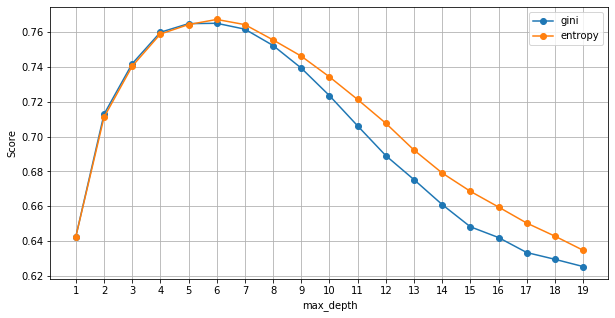

In [98]:
draw_multi(results_decision_tree, 'max_depth', 'DecisionTree')

In [101]:
print('Normalized: max_depth: 6, score: 0.7650920822949897')
print_max_multi(results_decision_tree, 'max_depth')

Normalized: max_depth: 6, score: 0.7650920822949897


'criterion: entropy, max_depth: 6, score: 0.7672459866794328'

Удалось улучшить общий скор, выбрав другой критерий: **0.7672459866794328**

## SGD Linear Classifier

Составим совместную таблицу среднего качества для функции потерь и регуляризатора

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
penalty = ['l1', 'l2', 'elasticnet']

columns = ['penalty'] + loss
results_sgd = pd.DataFrame([], columns=columns)

for pen in penalty:
    sgd = SGDClassifier(penalty=pen)

    clfSGD = GridSearchCV(sgd, {'loss': loss}, cv=5, n_jobs=-1, scoring='roc_auc')
    clfSGD.fit(train_X, train_y)
    new_result = pd.DataFrame([[pen] + list(clfSGD.cv_results_['mean_test_score'])], columns=columns)
    results_sgd = results_sgd.append(new_result, ignore_index=True)
    
results_sgd = results_sgd.set_index('penalty')

In [111]:
results_sgd

hinge       log  modified_huber  squared_hinge  perceptron
penalty                                                                  
l1          0.765189  0.767705        0.768370       0.773540    0.766035
l2          0.779670  0.778589        0.778426       0.779743    0.778444
elasticnet  0.780583  0.779647        0.780655       0.781160    0.778552

In [112]:
print('NOT normalized: loss: log, score: 0.780795529898613, std: 0.0066623699509413235')
print_max_multi(results_sgd, 'loss')

NOT normalized: loss: log, score: 0.780795529898613, std: 0.0066623699509413235


'penalty: elasticnet, loss: squared_hinge, score: 0.7811604984602963'

Так же немного удалось улучшить скор, выбрав другой регулятор

## RandomForest

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

criterion = ['gini', 'entropy']
n_estimators = [1546]
max_features = list(range(1, 2, 1))

params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
}

columns = ['criterion'] + max_features
results = pd.DataFrame([], columns=columns)

for cr in criterion:
    rft = RandomForestClassifier(criterion=cr)
    clfRFT = GridSearchCV(rft, params, cv=5, n_jobs=-1, scoring='roc_auc')
    clfRFT.fit(train_X, train_y)
    new_result = pd.DataFrame([[cr] + list(clfRFT.cv_results_['mean_test_score'])], columns=columns)
    results = results.append(new_result, ignore_index=True)

In [127]:
results = pd.read_csv("rf_max_features.csv").set_index('criterion')

In [126]:
results

1         2         3         4         5         6  \
criterion                                                               
gini       0.775919  0.775417  0.774363  0.773228  0.772056  0.771259   
entropy    0.776506  0.775565  0.774967  0.774386  0.773314  0.772627   

                  7         8         9        10        11        12  
criterion                                                              
gini       0.770608  0.769647  0.768947  0.768585  0.768207  0.767652  
entropy    0.772058  0.771400  0.771033  0.770365  0.770069  0.769683

In [131]:
print('NOT normalized: n_estimators: 4501, score: 0.7743684689543656, std: 0.007230779189479635')
print_max_multi(results, 'max_features')

NOT normalized: n_estimators: 4501, score: 0.7743684689543656, std: 0.007230779189479635


'criterion: entropy, max_features: 1, score: 0.7765063755129399'

## Выводы

Подбор нескольких гиперпараметров может улучшить общий скор модели. Все модели показали небольшое улучшение. Однако подбор нескольких гиперпараметров, вычислительно, очень затратно. Так что, практически единственный вариант, это жадный алгоритм, который, не гарантирует оптимальность, но даёт локальное улучшение.